# Building a mesh from GeoTIFF files

<div class="alert alert-block alert-info"> GeoTIFF files are raster dataset embedding Geographic Information (latitude, longitude, map projection etc.) The geographic data of a GeoTIFF file can be used to position the image in the correct location and geometry and build structured and unstructured meshes used in our landscape evolution model. </div> 




<div class="alert alert-block alert-info"> In this example, we use a dataset of the Australian Alps region that can be extracted from the ASTER Global DEM from USGS Global Data Explorer website: 
https://gdex.cr.usgs.gov/gdex/</div>

You can find an non-exhaustive list of available digital elvation dataset in the following website: 
+ https://github.com/openterrain/openterrain/wiki/Terrain-Data

![Region](https://github.com/Geodels/bioLEC/blob/master/src/bioLEC/Notebooks/images/kosinit.jpg?raw=true)


<div class="alert alert-block alert-danger"> 
To run this notebook you will need to first download your own Geotiff...</div>


## Notebook contents

   - [Converting from lon/lat to metres](#Converting-from-lon/lat-to-metres)
   - [Clipped elevation grid](#Clipped-elevation-grid)
   - [X & Y axes](#X-&-Y-axes)
   - [Structured elevation grid](#Structured-elevation-grid)

In [22]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import rasterio
from rasterio import crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# Converting from lon/lat to metres

To reproject the grid from **lon/lat** coordinates to **UTM** (metres) as required by **bioLEC**, a library is available within the **bioLEC** image:

+ `rasterio` -- https://github.com/mapbox/rasterio

First, we specify our DEM filename (the **Geotiff** file you have downloaded):

In [2]:
filename = 'dem.tif'

We also define the requested projection: we used **EPSG reference** for the region as an example `EPSG:32756` 

You can find a list of EPSG references from http://spatialreference.org/ref/epsg/. 

In [3]:
# Name of the reprojected UTM file to be created
outputfile = 'dem_reprojected.tif'

# Reproject to UTM zone 56 S in this case
dst_crs = 'EPSG:32756'

# Requested reprojected dataset resolution (metres)
utmRes = 50.

We then use the following cell to _make the projection_ and get the _interpolated elevation points_ (`elev` -- a numpy masked array)

In [4]:
with rasterio.open(filename) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    nodata = -32768.0
    with rasterio.open(outputfile, 'w', **kwargs) as dst:
        src_array = src.read()
        dst_array = np.empty((int(height), int(width)), dtype='int16')
        reproject(
            source=src_array, 
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,

            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
        elev = np.ma.masked_where(dst_array == nodata, dst_array)
elev = np.flipud(elev)

# Clipped elevation grid

We can visualise the new elevation array using the following function:

In [11]:
def plotElevation( data, cmin, cmax, colormap):
    '''
    data: dataset to plot
    cmin,cmax: extent of the colormap
    colormap: color scale to use   
    '''
    
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    
    ax = plt.gca()
    im = ax.imshow(np.flipud(data), interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

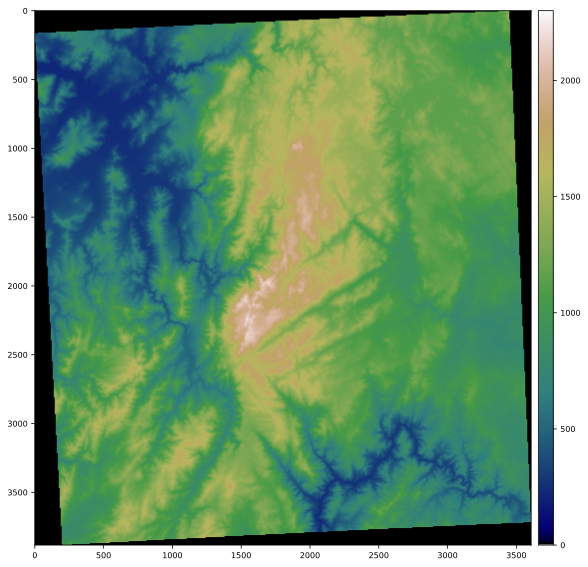

In [12]:
topocmap = 'gist_earth'
plotElevation( elev, 0, 2300, topocmap)

As you can see from the figure above, we will need to **clip** our array to remove the `nodata` values induced by the reprojection... We do that by just selecting the extent of the rows and columns number from our `elev` numpy array...

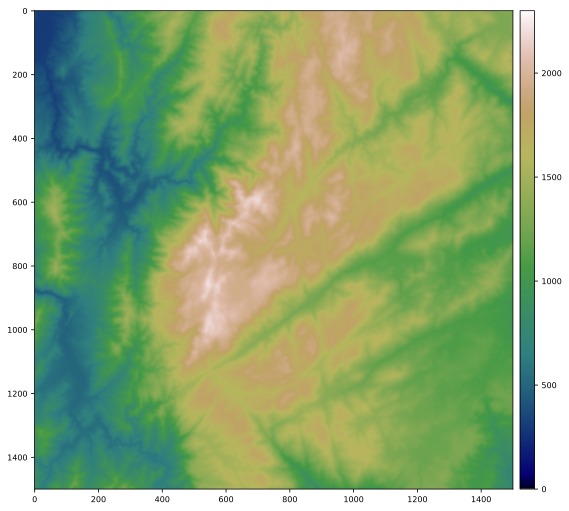

In [25]:
plotElevation( elev[1000:2500,1000:2500], 0, 2300, topocmap)

This extent seems to work :-), let's see if we still have some masked values

In [26]:
np.ma.is_masked(elev[1000:2500,1000:2500])

False

We then defined a new elevation array `dem` based on the clipped one:

In [27]:
dem = elev[1000:2500,1000:2500]

# X & Y axes

To keep your coordinates system for post-processing and to potentially reproject the outputs from **bioLEC** in another _geospatial system_ we need to specify the X and Y axes.

We do it like this:

In [28]:
xMin = dst.transform[2]
xMax = dst.transform[2] + abs(dst.transform[0])*width

yMin = dst.transform[5] - abs(dst.transform[4])*height
yMax = dst.transform[5]

print("Initial DEM:\n")

print("Lower left coordinates       Xmin: {}, Ymin: {}".format(xMin,yMin))
print("Upper right coordinates      Xmax: {}, Ymax: {}".format(xMax,yMax))

Initial DEM:

Lower left coordinates       Xmin: 32682.167735494382, Ymin: 5909501.812400085
Upper right coordinates      Xmax: 132595.90436793357, Ymax: 6017058.617577578


We can now create the X and Y coordinates, at this point we can choose to decrease the resolution if needed by using the `step` parameter (integer)

In [29]:
step = 2
spacing = utmRes*step
nZ = dem[::step,::step]

nx = nZ.shape[1]
ny = nZ.shape[0]

minX, maxX = xMin, xMin+spacing*nx
minY, maxY = yMin, yMin+spacing*ny

xcoords = np.arange(minX, maxX, spacing)
ycoords = np.arange(minY, maxY, spacing)

X, Y = np.meshgrid(xcoords, ycoords)

coords = np.vstack([X.ravel(), Y.ravel()])
coords = np.vstack([coords, nZ.ravel()]).T


print("Clipped DEM:\n")

print("Resolution (m)            res: {}".format(spacing))
print("Number of points         nbpt: {}".format(coords.shape[0]))
print("Elevation map shape        nx: {}, ny: {}\n".format(nx,ny))

print("Lower left coordinates   Xmin: {}, Ymin: {}".format(minX,minY))
print("Upper right coordinates  Xmax: {}, Ymax: {}".format(maxX,maxY))

Clipped DEM:

Resolution (m)            res: 100.0
Number of points         nbpt: 562500
Elevation map shape        nx: 750, ny: 750

Lower left coordinates   Xmin: 32682.167735494382, Ymin: 5909501.812400085
Upper right coordinates  Xmax: 107682.16773549438, Ymax: 5984501.812400085


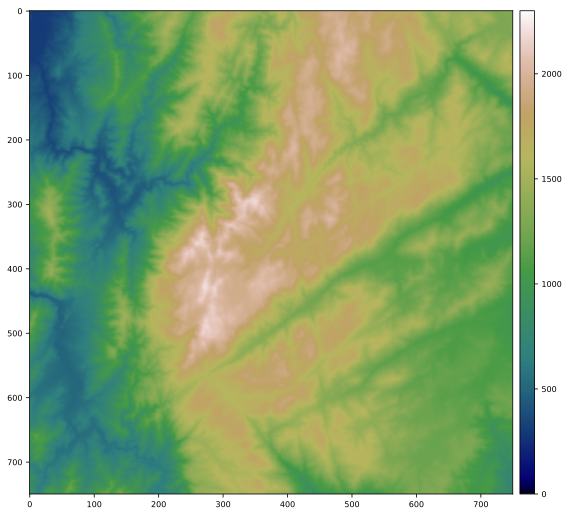

In [30]:
plotElevation( nZ, 0, 2300, 'gist_earth')

# Structured elevation grid

Finally we can use `pandas` library to write our new map on disk...

In [31]:
nameCSV = 'mountKoz.csv'

df = pd.DataFrame({'X':coords[:,0].flatten().astype(int),'Y':coords[:,1].flatten().astype(int),'Z':coords[:,2].flatten()})
df.to_csv(nameCSV,columns=['X', 'Y', 'Z'], sep=' ', index=False ,header=None)